In [22]:
# STEP 1: Install dependencies
!pip install transformers datasets evaluate nltk rouge_score --quiet


In [23]:
# STEP 2: Imports and setup
import os
import re
import torch
import nltk
import evaluate
import numpy as np
from nltk.tokenize import sent_tokenize
from datasets import load_dataset, DatasetDict
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)

try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

os.environ["WANDB_DISABLED"] = "true"


In [24]:
# STEP 3: Clean text
def clean_text(text):
    text = re.sub(r"[^\w\s.,!?-]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [25]:
# STEP 4: Load and prepare dataset
dataset = load_dataset("felixludos/babel-briefings", split="train")
dataset = dataset.filter(lambda x: x["language"] == "en" and x["content"] and x["title"])
dataset = dataset.remove_columns([col for col in dataset.column_names if col not in ["content", "title"]])
dataset = dataset.shuffle(seed=42)

# Use 5000 samples
subset = dataset.select(range(5000))
train_size = int(0.8 * len(subset))
val_size = int(0.1 * len(subset))

dataset_splits = DatasetDict({
    "train": subset.select(range(0, train_size)),
    "validation": subset.select(range(train_size, train_size + val_size)),
    "test": subset.select(range(train_size + val_size, len(subset)))
})


In [26]:
# STEP 5: Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")


In [27]:
# STEP 6: Preprocessing
def preprocess(batch):
    inputs = ["headline: " + clean_text(c) for c in batch["content"]]
    targets = [clean_text(t) for t in batch["title"]]
    model_inputs = tokenizer(inputs, max_length=128, padding="max_length", truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=32, padding="max_length", truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset_splits.map(preprocess, batched=True)


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 500/500 [00:00<00:00, 2963.84 examples/s]


In [29]:
# STEP 7: Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="/tmp/t5_headline_output",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=4,
    logging_dir="/tmp/logs",
    report_to="none",
    no_cuda=True,  
    evaluation_strategy="epoch",
    save_strategy="epoch"
)


In [30]:
# STEP 8: Define trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model)
)


/var/folders/kx/v_1zfg513n174gvs4f8kyk9w0000gn/T/ipykernel_57498/3596581270.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [31]:
# STEP 9: Train on MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
trainer.train()


Epoch,Training Loss,Validation Loss
1,2.674900,2.555214
2,2.625100,2.502061
3,2.545200,2.477234
4,2.437200,2.473821


TrainOutput(global_step=8000, training_loss=2.641712432861328, metrics={'train_runtime': 4674.4815, 'train_samples_per_second': 3.423, 'train_steps_per_second': 1.711, 'total_flos': 541367205888000.0, 'train_loss': 2.641712432861328, 'epoch': 4.0})

In [45]:
# STEP 10: Generate predictions on test set
def generate_headlines_on_test(model, tokenizer, test_set, num_samples=5):
    model.eval()
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    for i in range(min(num_samples, len(test_set))):
        sample = test_set[i]
        input_text = "headline: " + clean_text(sample["content"])
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            summary_ids = model.generate(
                inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=30,
                num_beams=5,
                length_penalty=1.2,
                early_stopping=True,
                no_repeat_ngram_size=2
            )

        generated = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        print(f"\n Sample #{i + 1}")
        print("Content:", sample["content"][:300], "...")
        print("Generated:", generated)
        print("Actual   :", sample["title"])


In [46]:
 # STEP 11: Run predictions
generate_headlines_on_test(model, tokenizer, dataset_splits["test"], num_samples=5)


 Sample #1
Content: Dwayne ‘The Rock’ Johnson made an appearance on Impact Wrestling’s Bound For Glory PPV. He was there to induct former rival and real-life friend Ken Shamrock. ‘The World’s Most Dangerous Man’ faced T… [+2422 chars] ...
Generated: Dwayne The Rock Johnson inducts former rival Ken Shamrock - PPV
Actual   : WWE Legend The Rock Makes a Special Appearance on Impact Wrestling - EssentiallySports

 Sample #2
Content: PanCAN staff members celebrate a previous World Pancreatic Cancer Day.
Put on all your purple World Pancreatic Cancer Day is Thursday, Nov. 19, 2020.
Wearing purple and spreading the word about pan… [+2970 chars] ...
Generated: PanCAN staff celebrate a previous World Pancreatic Cancer Day - Daily Mail
Actual   : 5 Ways to Take Action on World Pancreatic Cancer Day - Pancreatic Cancer News & Stories

 Sample #3
Content: Sussanne Khan with her friends (courtesy suzkr)
Highlights
<ul><li>Sussanne shared a selfie with her friends
</li><li>She captioned it with a q

In [47]:
# STEP 11: Compute ROUGE with regex-based sentence splitting
rouge = evaluate.load("rouge")

def split_sentences(text):
    return re.split(r'(?<=[.!?]) +', text)

def compute_rouge_score(model, tokenizer, dataset_subset):
    model.eval()
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    predictions, references = [], []

    for sample in dataset_subset:
        content = clean_text(sample["content"])
        input_text = "headline: " + content
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            summary_ids = model.generate(
                inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=20,
                num_beams=5,
                early_stopping=True,
                no_repeat_ngram_size=2
            )

        decoded_pred = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        decoded_ref = clean_text(sample["title"])

        predictions.append(decoded_pred.strip())
        references.append(decoded_ref.strip())

    decoded_preds = ["\n".join(split_sentences(pred)) for pred in predictions]
    decoded_refs = ["\n".join(split_sentences(ref)) for ref in references]

    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_refs, use_stemmer=True)
    return {k: round(v * 100, 2) for k, v in rouge_result.items()}


In [48]:
# STEP 12: Evaluate ROUGE on all splits
for split in ["train", "validation", "test"]:
    print(f"\nEvaluating {split} set...")
    subset = dataset_splits[split].select(range(50))
    scores = compute_rouge_score(model, tokenizer, subset)
    print(f" {split.capitalize()} ROUGE Scores:", scores)



Evaluating train set...
 Train ROUGE Scores: {'rouge1': 31.73, 'rouge2': 17.18, 'rougeL': 29.35, 'rougeLsum': 29.5}

Evaluating validation set...
 Validation ROUGE Scores: {'rouge1': 29.5, 'rouge2': 12.99, 'rougeL': 25.25, 'rougeLsum': 25.08}

Evaluating test set...
 Test ROUGE Scores: {'rouge1': 33.59, 'rouge2': 16.15, 'rougeL': 28.65, 'rougeLsum': 29.35}


In [49]:
import math
from torch.utils.data import DataLoader

def compute_perplexity(model, tokenizer, dataset_subset, batch_size=2):
    model.eval()
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    # Prepare DataLoader
    def collate_fn(batch):
        input_texts = ["headline: " + clean_text(example["content"]) for example in batch]
        target_texts = [clean_text(example["title"]) for example in batch]
        
        inputs = tokenizer(input_texts, padding="longest", truncation=True, return_tensors="pt", max_length=512)
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(target_texts, padding="longest", truncation=True, return_tensors="pt", max_length=64)

        inputs["labels"] = labels["input_ids"]
        return {k: v.to(device) for k, v in inputs.items()}

    dataloader = DataLoader(dataset_subset, batch_size=batch_size, collate_fn=collate_fn)
    
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in dataloader:
            outputs = model(**batch)
            loss = outputs.loss
            num_tokens = torch.sum(batch["labels"] != -100)
            total_loss += loss.item() * num_tokens
            total_tokens += num_tokens

    avg_neg_log_likelihood = total_loss / total_tokens
    perplexity = math.exp(avg_neg_log_likelihood)
    return round(perplexity, 4)


In [50]:
print("\nCalculating Perplexity:")
for split in ["train", "validation", "test"]:
    subset = dataset_splits[split].select(range(50))
    ppl = compute_perplexity(model, tokenizer, subset)
    print(f" {split.capitalize()} Perplexity: {ppl}")



Calculating Perplexity:


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


 Train Perplexity: 12.9991
 Validation Perplexity: 18.1387
 Test Perplexity: 14.6997


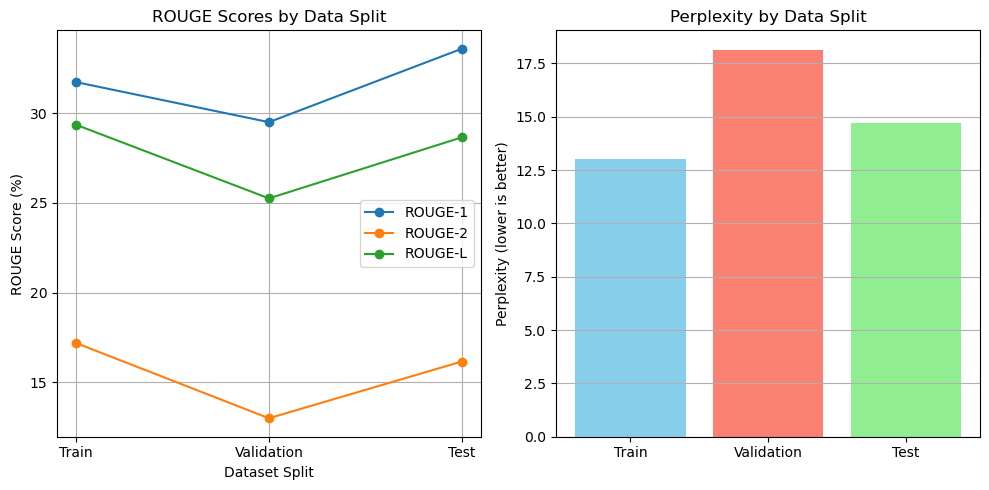

In [51]:
import matplotlib.pyplot as plt

# Manually enter your results
splits = ["Train", "Validation", "Test"]

# ROUGE Scores (%)
rouge1 = [31.73, 29.50, 33.59]
rouge2 = [17.18, 12.99, 16.15]
rougeL = [29.35, 25.25, 28.65]

# Perplexity Scores
perplexity = [12.9991, 18.1387, 14.6997]

# Plot ROUGE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(splits, rouge1, marker='o', label="ROUGE-1")
plt.plot(splits, rouge2, marker='o', label="ROUGE-2")
plt.plot(splits, rougeL, marker='o', label="ROUGE-L")
plt.title("ROUGE Scores by Data Split")
plt.xlabel("Dataset Split")
plt.ylabel("ROUGE Score (%)")
plt.legend()
plt.grid(True)

# Plot Perplexity
plt.subplot(1, 2, 2)
plt.bar(splits, perplexity, color=["skyblue", "salmon", "lightgreen"])
plt.title("Perplexity by Data Split")
plt.ylabel("Perplexity (lower is better)")
plt.grid(True, axis="y")

plt.tight_layout()
plt.show()
